### Fit GLM per animal per bin

In [1]:
# Imports
import autograd.numpy as np
import autograd.numpy.random as npr
import os
import matplotlib.pyplot as plt
from glm_utils import load_session_fold_lookup, load_data, load_animal_list, \
    fit_glm, plot_input_vectors, append_zeros, calculate_predictive_acc_glm

npr.seed(65)

In [2]:
"""
Load data
"""
data_dir = '/home/ines/repositories/representation_learning_variability/DATA/GLMHMM/'
processed_ibl_data_path = data_dir + "data_for_cluster/" + "data_by_bin/"
# Load animal list/results of partial processing:
animal_list = load_animal_list(
    data_dir + 'animal_list.npz')


In [3]:
"""
Some parameters
"""
C = 2  # number of output types/categories
N_initializations = 1
num_folds = 5
num_bins = 10

In [4]:
"""
Create directory for saving results
"""
results_dir = '../../results/ibl_individual_fit/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

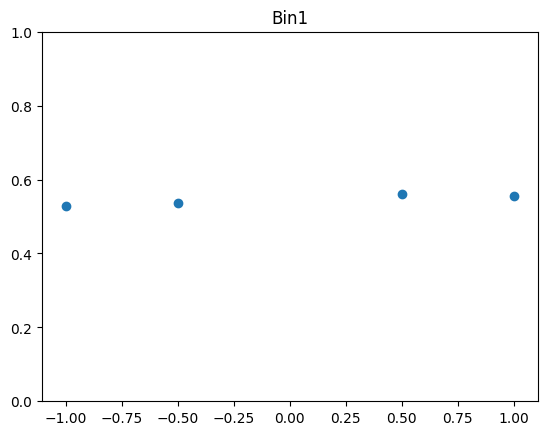

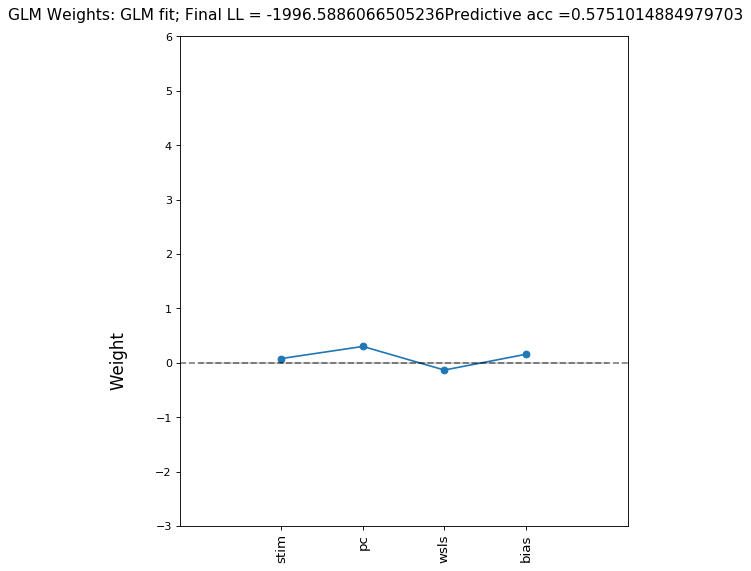

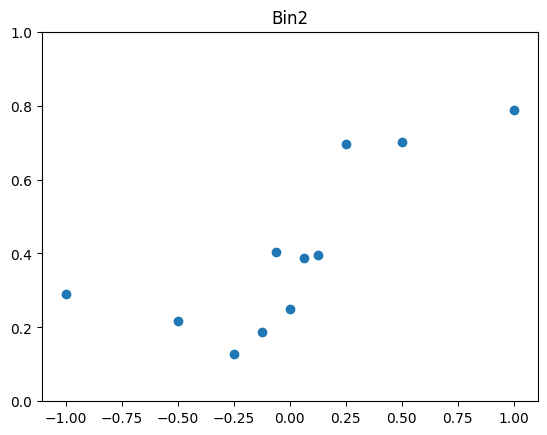

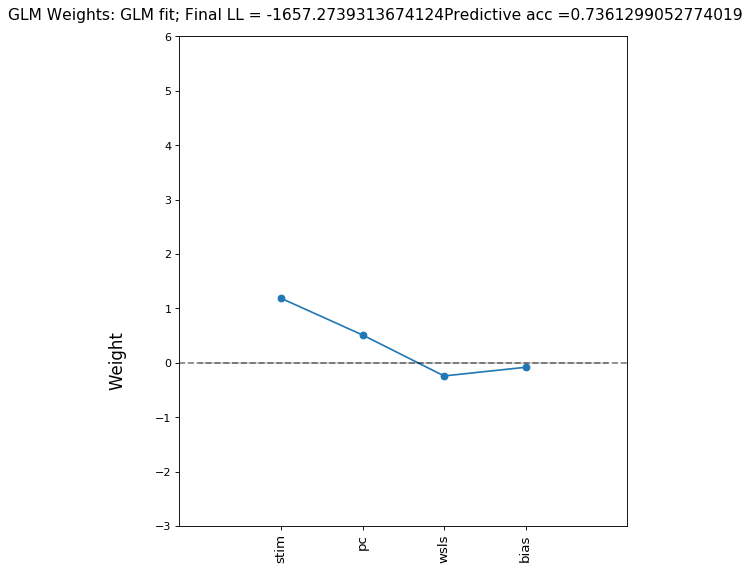

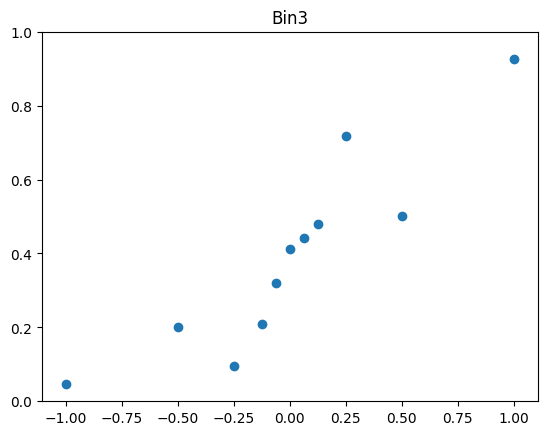

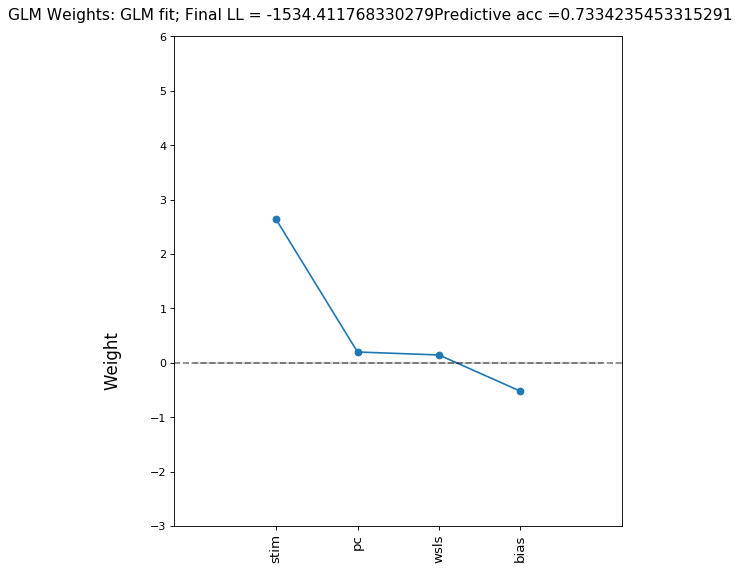

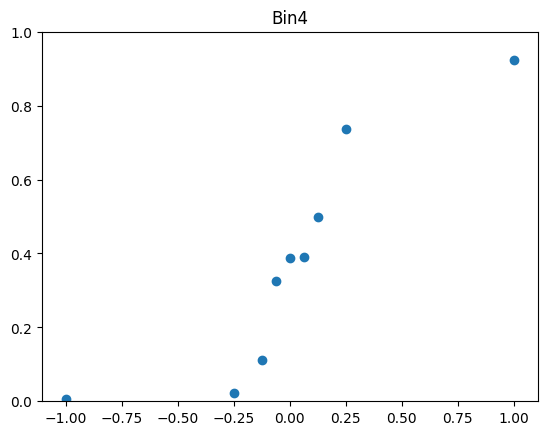

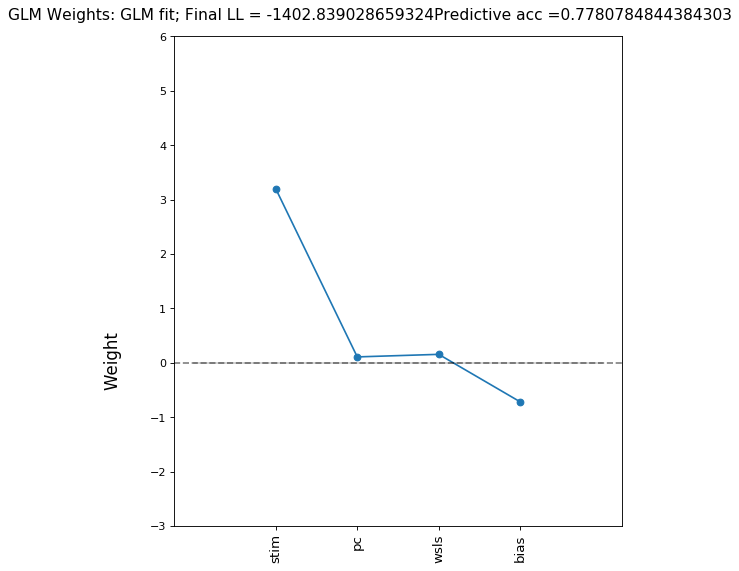

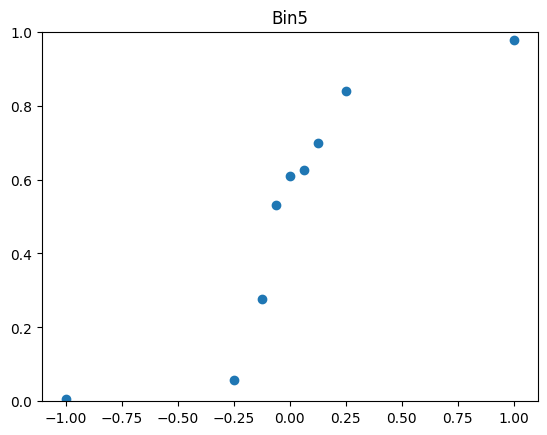

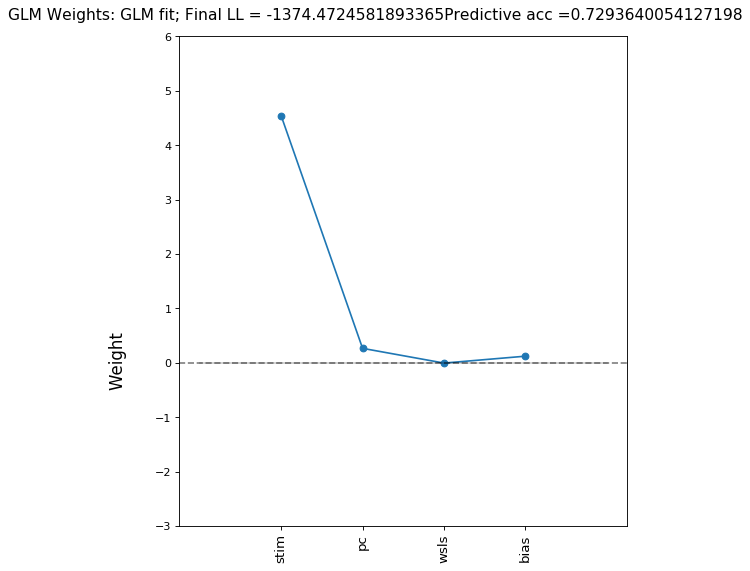

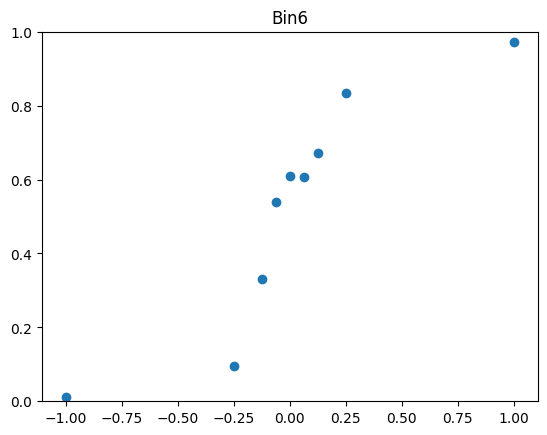

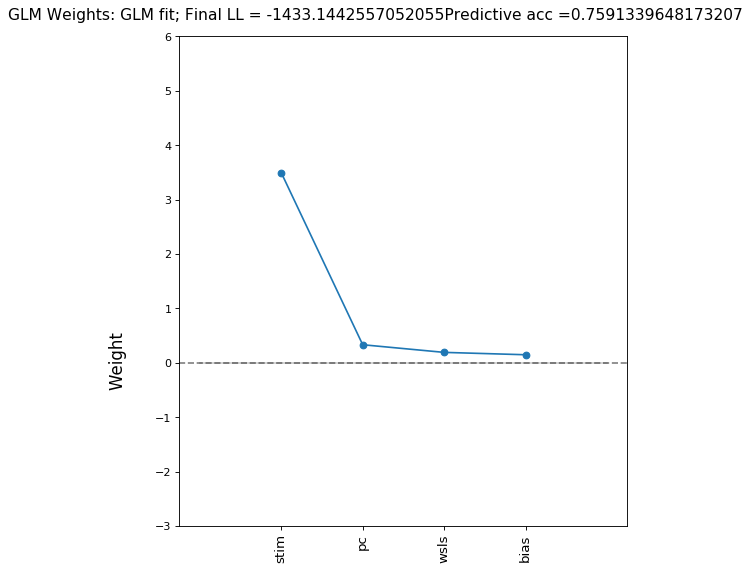

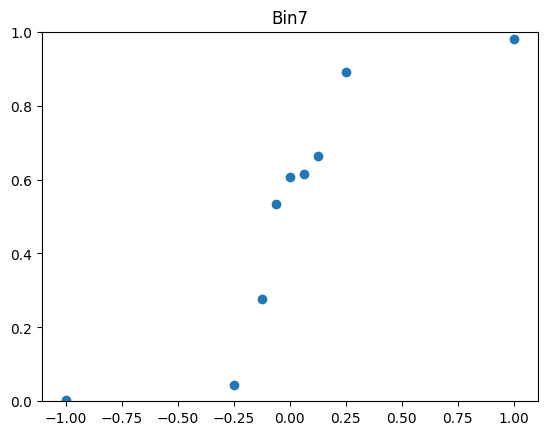

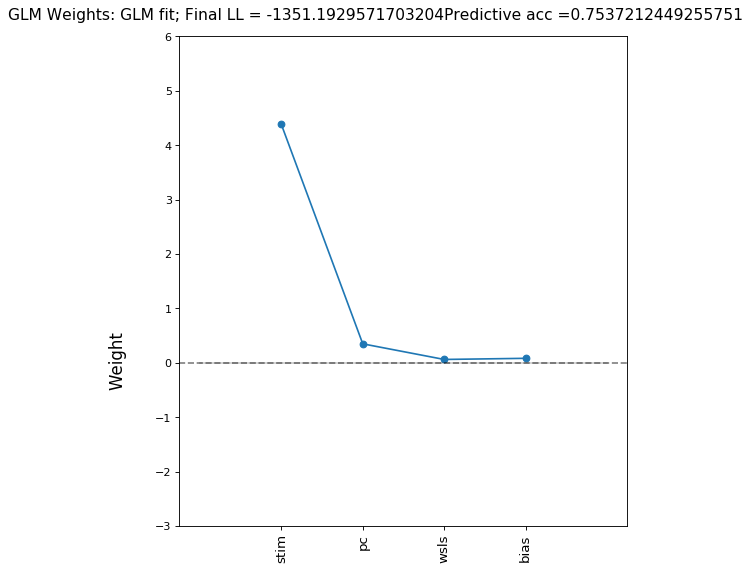

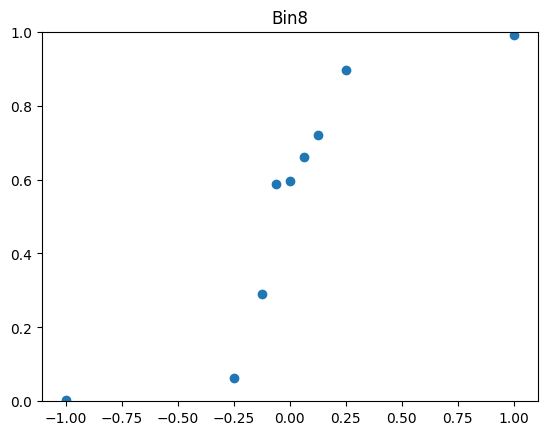

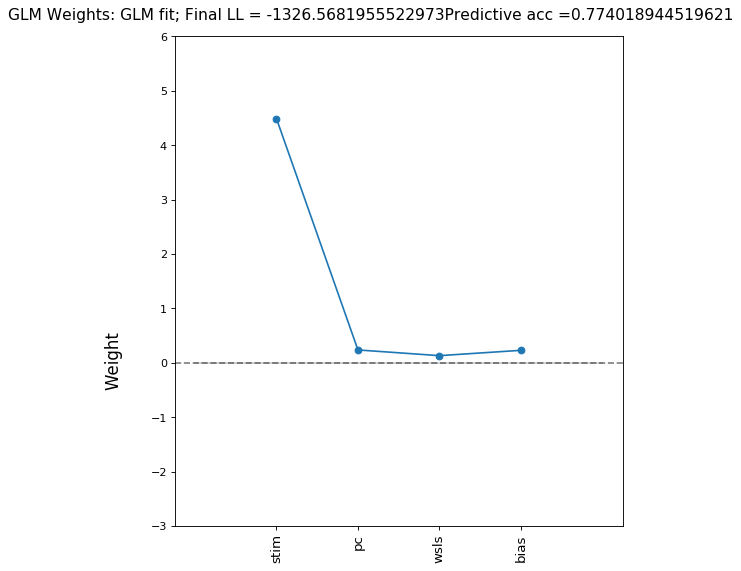

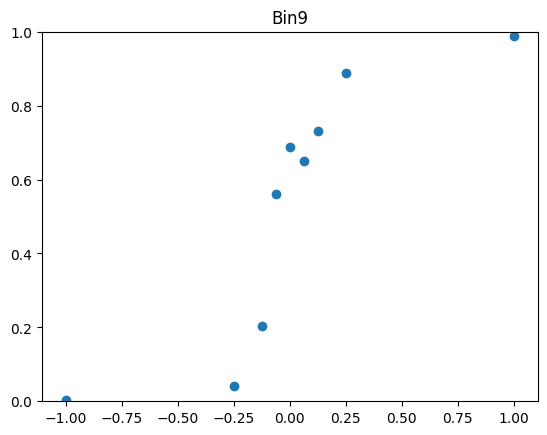

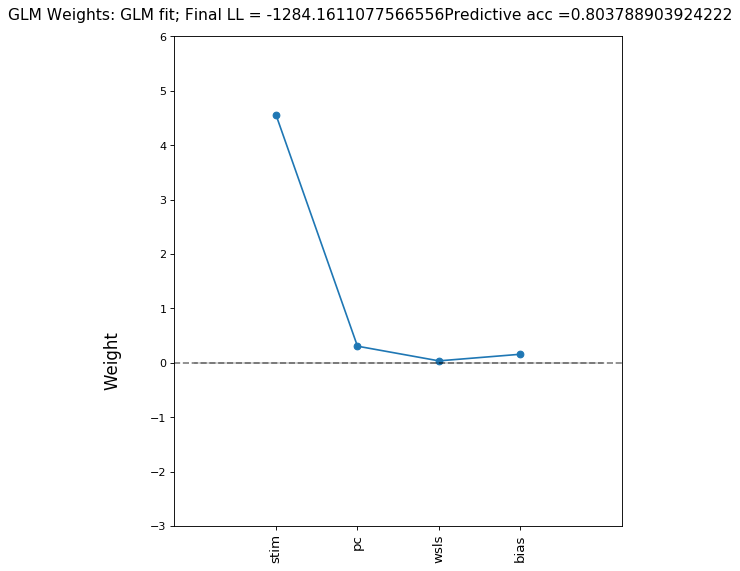

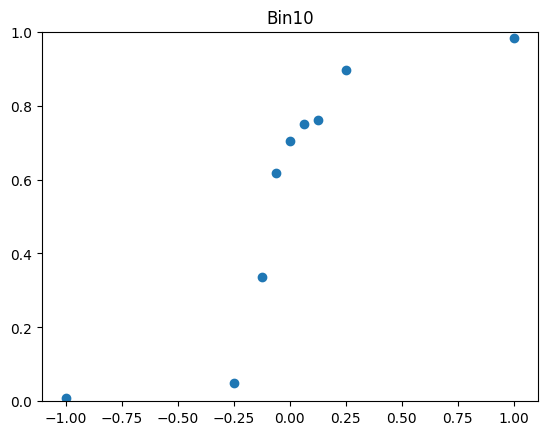

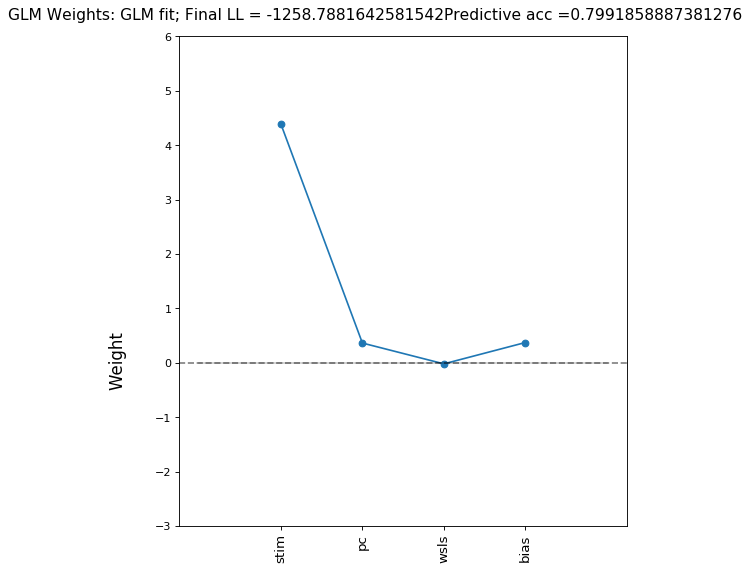

In [7]:
# Loop through bins
for b, bin in enumerate(range(num_bins)):
    animal_list = load_animal_list(
    processed_ibl_data_path + 'animal_list_bin_' + str(bin+1) +'.npz')
    
    # Loop through animals in the bin
    for animal in animal_list[10:11]:
        # Fit GLM to data from single animal:
        animal_file = processed_ibl_data_path + animal + '_bin_' + str(bin+1) + '_processed.npz'
        bin_fold_lookup_table = load_session_fold_lookup(
            processed_ibl_data_path + animal + '_' + str(bin+1)+ '_bin_fold_lookup.npz')

        unnormalized_data = processed_ibl_data_path + animal + '_' + str(bin+1) + '_unnormalized.npz'
        
        # Check psychometric curves!
        un_inpt, un_y, un_bin_data = load_data(unnormalized_data)
        plt.figure()
        x_stim = np.unique(un_inpt[:, 0])
        y_stim = np.zeros(len(x_stim))
        
        for s, stimulus in enumerate(x_stim):
            y_stim[s] = np.nanmean(un_y[np.where(un_inpt[:, 0]==stimulus), 0])
        plt.scatter(x_stim, y_stim)
        plt.title('Bin' + str(bin+1))
        plt.ylim([0,1])
            
        for fold in range(num_folds):
            this_results_dir = results_dir + animal + '_' + str(bin+1) + '/'

            # Load data
            inpt, y, bin_data = load_data(animal_file)
            labels_for_plot = ['stim', 'pc', 'wsls', 'bias']
            y = y.astype('int')

            figure_directory = this_results_dir + "GLM/fold_" + str(fold) + '/'
            if not os.path.exists(figure_directory):
                os.makedirs(figure_directory)

            # Subset to trials of interest for fold

            trials_idx = np.arange(len(y))
            keep_fold = trials_idx[
                np.where(bin_fold_lookup_table != fold)]  # TODO: what is y == -1?

            keep_y = [y[id, 0] != -1
                for id, binn in enumerate(trials_idx)]
            keep_y = trials_idx[keep_y]
            idx_to_keep = np.sort(np.intersect1d(keep_y, keep_fold))
            idx_this_fold = trials_idx[idx_to_keep]
            
            this_inpt, this_y, this_session = inpt[idx_this_fold, :], \
                                                y[idx_this_fold, :], \
                                                bin_data[idx_this_fold]
            
            # Subset to trials for calculation of predictive accuracy
            # TODO
            left_out_fold = trials_idx[
                np.where(bin_fold_lookup_table == fold)]  
            
            if len(np.unique(this_y)) == 2:
                
                # This assertion is redundant
                assert len(
                    np.unique(this_y)
                ) == 2, "choice vector should only include 2 possible values"
                
                train_size = this_inpt.shape[0]

                M = this_inpt.shape[1]
                loglikelihood_train_vector = []
                pred_acc_vector = []

                for iter in range(N_initializations):
                    loglikelihood_train, recovered_weights = fit_glm([this_inpt],
                                                                        [this_y], M,
                                                                        C)
                    weights_for_plotting = append_zeros(recovered_weights)
                    # Calculate predictive accuracy based on left out fold 
                    predictive_acc = calculate_predictive_acc_glm(recovered_weights, inpt, y, left_out_fold)
                    
                    if iter == 0 and fold == 0:
                        plot_input_vectors(weights_for_plotting,
                                            figure_directory,
                                            title="GLM fit; Final LL = " +
                                            str(loglikelihood_train) + "Predictive acc =" + str(predictive_acc),
                                            save_title='init' + str(iter),
                                            labels_for_plot=labels_for_plot)
                    
                    loglikelihood_train_vector.append(loglikelihood_train)
                    pred_acc_vector.append(predictive_acc)
                    
                    # Save model results
                    np.savez(
                        figure_directory + 'variables_of_interest_iter_' +
                        str(iter) + '.npz', loglikelihood_train, recovered_weights, predictive_acc)